# Sepsis Model Comparison

In this notebook, several different machine learning models will be trained, tested, compared and honed in attempting to out perform the benchmark study and achieve high accuracy.

## Attain and Pre-Process Data

Data will be pre-processed in the same manner as the previous notebook but most heavy lifting will be offloaded to the helper python file mimicpreprocess.py. This file contains nearly the identical code as the previous exploratory notebook.

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb

import sklearn.preprocessing as skpp
from sklearn.grid_search import RandomizedSearchCV
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.cross_validation import train_test_split

import datetime

import matplotlib.pyplot as plt

from mimicpreprocess import DataHandler

In [2]:
dh = DataHandler()
dh.connect()

In [3]:
admissions = dh.admissions_query()
patients = dh.patient_query()
dh.prior_hospital_stays(admissions)

In [4]:
# Join patients and admission dataframes to obtain gender and age of patient
patient_info = admissions.join(patients.set_index('subject_id'), on='subject_id')

In [5]:
patient_info['age'] = patient_info.apply (lambda row: dh.age (row),axis=1)

In [6]:
patient_vitals = dh.lab_event_query(patient_info)

In [7]:
patient_vitals.isnull().sum()

oxygen                   836
pco2                     412
PH                       355
po2                      412
tempurature              634
lipase                   436
hematocrit                 9
hemoglobin                10
INR                       68
lymphocytes               58
alkaline phosphatase     198
MCH                       11
amylase                  627
neutrophils               58
BUN                        8
platelet                   8
bicarbonate               14
CRP                      993
PTT                       68
PT                        72
RBCDW                     10
calcium                   23
ESR                     1120
creatinine                 8
WBC                     1172
glucose                    9
AST                      183
lactate                   86
dtype: int64

In [8]:
from itertools import chain
# Vitals that will be kept. The rest dropped due to lack of data
keep_vitals = ['bicarbonate' ,'INR' ,'MCH' ,'AST','alkaline phosphatase' , 'creatinine', 'platelet', 'PT', 'PTT', 'lymphocytes', 'RBCDW', 'calcium', 'neutrophils', 'glucose', 'hematocrit', 'hemoglobin', 'lactate', 'BUN']
patient_vitals_fixed = patient_vitals[keep_vitals]

In [9]:
# Find all hadm_ids where there are 6 or greater missing values. 
drop_hadm_ids = patient_vitals_fixed[patient_vitals_fixed.isnull().sum(axis=1) >= 6].index

In [10]:
patient_vitals_final = patient_vitals_fixed[~patient_vitals_fixed.index.isin(drop_hadm_ids)]

In [11]:
# Replace NaN values with the mean of each column. In the actual ML phase it may be worth figuring out WHY
# Some values are missing. Here we will simply continue with mean.
patient_vitals_final = patient_vitals_final.fillna(patient_vitals.mean())

In [12]:
# Add age column prior to standardization
keep_vitals = keep_vitals + ['age', 'prior']

In [13]:
patient_info = patient_info[~patient_info.hadm_id.isin(drop_hadm_ids)]

### Standardize Data
Standardize data by fitting the dataframe to the Scikit learn preprocessing StandardScaler object. This refits all data to be zero-mean.

In [14]:
# New patient info dataframe finally with vitals
vital_patient_info = patient_info.join(patient_vitals_final, on='hadm_id')

# Standardize the data from vital columns
stdsc = skpp.StandardScaler()
vital_patient_info[keep_vitals] = stdsc.fit_transform(vital_patient_info[keep_vitals])

### Remove Outliers
Quick loop to locate and remove entries that are outliers in 4 or more columns. This is useful since much medical data contains skewed results.

In [15]:
potential_outliers = []
from collections import Counter
from IPython.display import display

# For each feature find the data points with extreme high or low values
for feature in patient_vitals_final.keys():

    # Calculate Q1
    Q1 = np.percentile(patient_vitals_final[feature], 25)
    
    # Calculate Q3
    Q3 = np.percentile(patient_vitals_final[feature], 75)
    
    step = 1.5*(Q3-Q1)
    
    # Display the outliers
    outlier = patient_vitals_final[~((patient_vitals_final[feature] >= Q1 - step) & (patient_vitals_final[feature] <= Q3 + step))]
    potential_outliers += outlier.index.tolist()
    
# print Counter(potential_outliers)
# len({k:v for (k,v) in Counter(potential_outliers).items() if v > 4})
outliers = [k for (k,v) in Counter(potential_outliers).items() if v > 4]

In [16]:
vital_patient_info = vital_patient_info[~vital_patient_info.index.isin(outliers)]

## Feature Selection
Identify features that are useful for predicting the survivability of sepsis by training a random forest and using the fitted model's feature importance attribute to locate columns to drop.

In [17]:
y_vitals = vital_patient_info['death_period']
X_vitals = vital_patient_info.drop(['death_period', 'subject_id', 'hadm_id', 'admittime', 'admission_type', 'insurance', 'ethnicity', 'dob', 'gender', 'prior', 'INR', 'lymphocytes', 'glucose', 'hemoglobin'], 1) 
X_vitals = pd.get_dummies(X_vitals)

In [18]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {
              "n_estimators": list(range(1,1000)),
             }

forest = RandomForestClassifier( random_state=42)

In [19]:
rand_for = RandomizedSearchCV(forest, param_grid, scoring = 'roc_auc', n_iter=20, random_state=42)
_ = rand_for.fit(X_vitals,y_vitals)

In [20]:
print(rand_for.best_score_)
print(rand_for.best_params_)
print(rand_for.best_estimator_)

0.798011265838
{'n_estimators': 215}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=215, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)


In [21]:
importances = rand_for.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_vitals.shape[1]):
    print "{}) {} {}".format(f, X_vitals.columns[indices[f]], importances[indices[f]])

0) lactate 0.120621919702
1) bicarbonate 0.0891480184635
2) BUN 0.085720846552
3) PT 0.0681547584876
4) calcium 0.0637462535571
5) AST 0.0629394890653
6) RBCDW 0.0618520313594
7) hematocrit 0.0608084056982
8) creatinine 0.0599723450538
9) PTT 0.0584180822359
10) alkaline phosphatase 0.0569462415418
11) platelet 0.0555460145788
12) neutrophils 0.0543934466281
13) MCH 0.0533024113793
14) age 0.0484297356972


## Support Vector Machine

In [22]:
from sklearn.svm import SVC

In [23]:
sv_clf = SVC(random_state=42)

param_grid = {'C': [ 0.0001, 0.001, 0.01, 1, 100, 1000, 2000, 2500, 3000], 
              'gamma': [ 0.01, 0.001, 0.002, 0.003, 0.004, 0.005, 0.0001], 
              'kernel': ['rbf']
              }

In [24]:
grid_sv = GridSearchCV(sv_clf, param_grid, cv=10, scoring="roc_auc")
grid_sv.fit(X_vitals,y_vitals)

GridSearchCV(cv=10, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'kernel': ['rbf'], 'C': [0.0001, 0.001, 0.01, 1, 100, 1000, 2000, 2500, 3000], 'gamma': [0.01, 0.001, 0.002, 0.003, 0.004, 0.005, 0.0001]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [25]:
print(grid_sv.best_score_)
print(grid_sv.best_params_)
print(grid_sv.best_estimator_)

0.796466405468
{'kernel': 'rbf', 'C': 1, 'gamma': 0.01}
SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)


## Adaptive Boosting

In [26]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

stump_clf =  DecisionTreeClassifier(random_state=42, max_depth=1)

param_grid = {
              "n_estimators": list(range(1,500)),
              "learning_rate": np.linspace(0.01, 1, num=20),
             }

ada_clf = AdaBoostClassifier(base_estimator = stump_clf)

In [27]:
rand_ada = RandomizedSearchCV(ada_clf, param_grid, scoring = 'roc_auc', n_iter=100, random_state=42)
rand_ada.fit(X_vitals,y_vitals)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=None),
          fit_params={}, iid=True, n_iter=100, n_jobs=1,
          param_distributions={'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,...316,
        0.63526,  0.68737,  0.73947,  0.79158,  0.84368,  0.89579,
        0.94789,  1.     ])},
          pre_dispatch='2*n_jobs', random_state=42, refit=

In [28]:
print(rand_ada.best_score_)
print(rand_ada.best_params_)
print(rand_ada.best_estimator_)

0.767912152865
{'n_estimators': 32, 'learning_rate': 0.16631578947368422}
AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=0.16631578947368422, n_estimators=32,
          random_state=None)


## Extreme Gradient Boosting

In [29]:
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import cross_val_score

In [30]:
param_grid = {
                "max_depth": list(range(1,20)),
                "gamma": list(range(0, 20)),
                "min_child_weight":list(range(0,20)),
                "n_estimators": list(range(1,200)),
                "learning_rate": [i/10.0 for i in range(0,10)], 
             }

In [31]:
rand_XGB = RandomizedSearchCV(xgb.XGBClassifier(objective='binary:logistic'), 
                              param_grid, scoring='roc_auc', n_iter=100, random_state=42)
_ = rand_XGB.fit(X_vitals,y_vitals)

In [32]:
print(rand_XGB.best_score_)
print(rand_XGB.best_params_)
print(rand_XGB.best_estimator_)

0.790493961541
{'n_estimators': 47, 'gamma': 5, 'learning_rate': 0.1, 'max_depth': 14, 'min_child_weight': 9}
XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=5, learning_rate=0.1, max_delta_step=0, max_depth=14,
       min_child_weight=9, missing=None, n_estimators=47, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)


## Neural Network with Keras/TensorFlow

In [33]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras.constraints import maxnorm
from keras.callbacks import Callback

model = Sequential()

Using TensorFlow backend.


In [34]:
class Histories(Callback):
    def __init__(self, validation_data=()):
        super(Callback, self).__init__()

        self.X_val, self.y_val = validation_data
        
    def on_train_begin(self, logs={}):
        self.aucs = []
        self.losses = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        y_pred = self.model.predict_proba(self.X_val, verbose=0)
        self.aucs.append(roc_auc_score(self.y_val, y_pred))
        return


In [55]:
model = Sequential()

model.add(Dense(125, input_dim=len(X_vitals.columns), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu', kernel_constraint=maxnorm(5)))
model.add(Dropout(0.5))
model.add(Dense(25, activation='relu', kernel_constraint=maxnorm(5)))
model.add(Dropout(0.5))
model.add(Dense(10, activation='relu', kernel_constraint=maxnorm(5)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X_vitals, y_vitals, test_size=0.33, random_state=42)

In [57]:
histories = Histories(validation_data=(X_test.as_matrix(), y_test.as_matrix()))

history = model.fit(X_train.as_matrix(), y_train.as_matrix(), verbose=0, validation_data=(X_test.as_matrix(), y_test.as_matrix()), epochs=500, batch_size=128, callbacks=[histories])



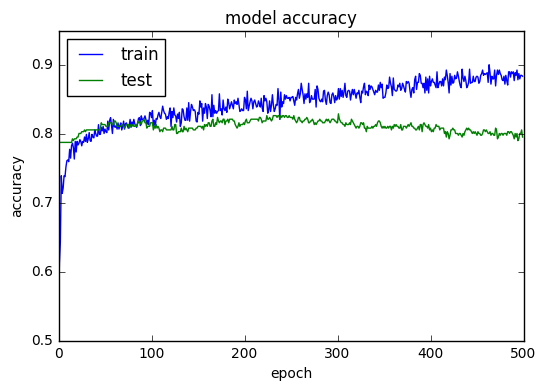

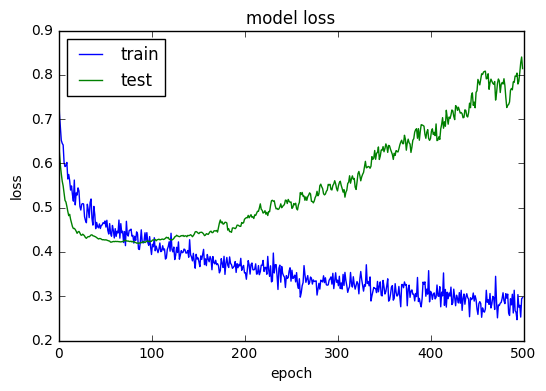

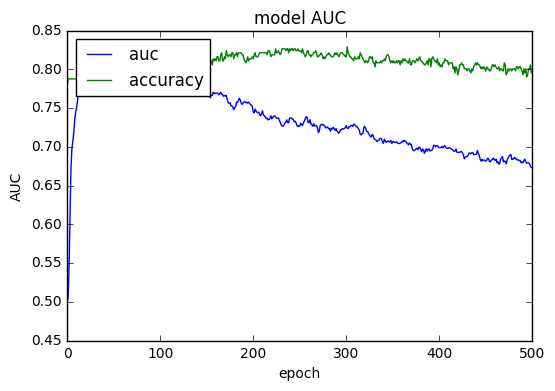

In [58]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Plot AUC
plt.plot(histories.aucs)
plt.plot(history.history['val_acc'])
# plt.plot(history.history['val_loss'])
plt.title('model AUC')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['auc', 'accuracy', 'loss'], loc='upper left')

plt.show()

In [59]:
print "Best Epoch: {}".format(histories.aucs.index(max(histories.aucs)))
print "Best Auc: {}".format(max(histories.aucs))
print "Best Accuracy: {}".format(history.history['val_acc'][histories.aucs.index(max(histories.aucs))])

Best Epoch: 26
Best Auc: 0.793084082157
Best Accuracy: 0.80310880829


## Conclusion

While all models performed better than the benchmark after some tweaking, the SVM performed much better at around 0.796 ACU. This is impressive and useful in stratifying patients for further analysis and study. The neural network was much more challenging to design and optimize and it is likely that an even more optimal solution exists, however it did not beat the SVM and was more apt to overfitting.

This exercise has proven that pre-processing the data and optimizing the model are the most time consuming steps and require a lot of consideration and practice.